In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, datetime
import time


pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline

height has been deprecated.



In [2]:
df = pd.read_json('files/data.json')

In [322]:
#original = df.copy()
df = original.copy()

In [3]:
def reduce_to_premium_and_fraudsters(df, inplace=False):
    try:
        if (inplace):
            df = df[(df.acct_type == 'premium') | (df.acct_type == 'fraudster_event') | (df.acct_type == 'fraudster')]
        else:
            return df[(df.acct_type == 'premium') | (df.acct_type == 'fraudster_event') | (df.acct_type == 'fraudster')]
    except e:
        print("Error", e)

df = reduce_to_premium_and_fraudsters(df)


### Creating a Fraud predictor variable
- Initialized to 0
- If the acct_type was fraudster_event of fraudster, set Fraud to 1

In [4]:
def create_fraud_feature(df, inplace=False):
    daf = df.copy()
    daf['Fraud'] = 0
    for i, row in daf.iterrows():
        if row.acct_type == 'fraudster_event' or row.acct_type == 'fraudster':
            daf.set_value(i, 'Fraud', 1)
    if inplace:
        df = daf
    else:
        return daf
df = create_fraud_feature(df)

### Dropping rows that are null

In [5]:
def drop_nulls_in_cols(df, cols=['event_published', 'delivery_method', 'country', 'org_facebook', 'org_twitter', 'sale_duration', 'venue_country', 'venue_latitude', 'venue_longitude', 'venue_name', 'venue_state'], inplace=False):
    daf = df.copy()
    daf = daf.dropna(subset=cols)
    if inplace:
        df = daf
    else:
        return daf
df = drop_nulls_in_cols(df)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12452 entries, 0 to 14336
Data columns (total 45 columns):
acct_type             12452 non-null object
approx_payout_date    12452 non-null int64
body_length           12452 non-null int64
channels              12452 non-null int64
country               12452 non-null object
currency              12452 non-null object
delivery_method       12452 non-null float64
description           12452 non-null object
email_domain          12452 non-null object
event_created         12452 non-null int64
event_end             12452 non-null int64
event_published       12452 non-null float64
event_start           12452 non-null int64
fb_published          12452 non-null int64
gts                   12452 non-null float64
has_analytics         12452 non-null int64
has_header            7788 non-null float64
has_logo              12452 non-null int64
listed                12452 non-null object
name                  12452 non-null object
name_length      

## Handling dates
#### All the dates in the dataset are in unix format, so unix_to_days will convert them into days from today


In [7]:
def unix_to_days(x):
    today = datetime.today()
    return (today - pd.to_datetime(float(x), unit='s')).days

In [ ]:
df['event_created'] = df['event_created'].map(lambda x: unix_to_days(x))
df['event_published'] = df['event_published'].map(lambda x: unix_to_days(x))
df['event_start'] = df['event_start'].map(lambda x: unix_to_days(x))
df['event_end'] = df['event_end'].map(lambda x: unix_to_days(x))
df['user_created'] = df['user_created'].map(lambda x: unix_to_days(x))
df['approx_payout_date'] = df['approx_payout_date'].map(lambda x: unix_to_days(x))

### Columns we dont want
- user_age
- listed
- country

In [329]:
df['event_duration'] = df['event_start'] - df['event_end']
df['event_created_to_end'] = df['event_created'] - df['event_end']

In [ ]:
from datetime import datetime
def unix_to_days(x):
    today = datetime.today()
    return (today - pd.to_datetime(float(x), unit='s')).days

def event_created_to_end(df):
    daf = df.copy()
    daf['event_created'] = daf['event_created'].map(lambda x: unix_to_days(x))
    daf['event_end'] = daf['event_end'].map(lambda x: unix_to_days(x))
    daf['event_created_to_end'] = daf['event_created'] - daf['event_end']
    return daf



In [330]:
df = df.drop(['description', 'acct_type', 'has_header', 'event_start', 'event_end', 'name', 'object_id', 'org_desc', 'org_name', 'payee_name', 'previous_payouts', 'venue_address', 'venue_name'], axis=1)

In [331]:
df = df.drop(['email_domain', 'approx_payout_date', 'currency', 'event_created', 'event_published', 'venue_country', 'venue_latitude', 'venue_longitude', 'venue_state'], axis=1)

In [332]:
countries = ['US', 'GB', 'CA', 'AU']
for i, row in df.iterrows():
    if row['country'] not in countries:
        df.set_value(i, 'country', 'Other')

In [333]:
df_countries = pd.get_dummies(df['country'])
df = pd.concat([df, df_countries], axis=1)


In [334]:
df = df.drop(['country'], axis=1)

In [335]:
df = df.convert_objects(convert_numeric=True)

/Users/zachary/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [336]:
df['payout_type'] = df['payout_type'].replace('', 'MISSING')

In [337]:
df_listed = pd.get_dummies(df['listed'])
df = pd.concat([df, df_listed], axis=1)
df.pop('listed')

0        y
1        n
2        y
4        y
5        y
6        y
7        y
8        y
9        y
10       y
11       y
12       y
14       n
15       y
16       y
17       y
18       y
19       y
20       y
21       y
22       y
23       y
24       y
25       y
26       n
27       y
28       y
29       y
30       n
31       y
34       y
35       y
36       y
37       y
38       y
39       y
40       y
41       y
42       y
43       y
44       y
45       y
46       y
47       y
49       y
50       y
51       y
52       y
53       y
54       y
55       y
56       y
57       y
58       y
59       y
60       y
61       y
62       y
63       y
64       y
66       y
67       y
68       y
69       y
70       n
71       y
72       y
73       y
74       y
75       y
76       y
77       y
79       y
80       n
82       y
83       y
85       y
86       y
87       y
88       y
89       y
90       y
91       y
93       n
95       y
96       y
97       y
98       y
99       y
100      y
101      y

In [338]:
df_payout_type = pd.get_dummies(df['payout_type'])
df = pd.concat([df, df_payout_type], axis=1)
df.pop('payout_type')

0        MISSING
1          CHECK
2          CHECK
4          CHECK
5          CHECK
6            ACH
7            ACH
8            ACH
9            ACH
10         CHECK
11           ACH
12         CHECK
14         CHECK
15         CHECK
16         CHECK
17         CHECK
18           ACH
19           ACH
20           ACH
21         CHECK
22         CHECK
23         CHECK
24         CHECK
25           ACH
26           ACH
27         CHECK
28           ACH
29           ACH
30         CHECK
31           ACH
34           ACH
35           ACH
36         CHECK
37         CHECK
38           ACH
39         CHECK
40           ACH
41           ACH
42         CHECK
43         CHECK
44           ACH
45           ACH
46           ACH
47           ACH
49         CHECK
50           ACH
51         CHECK
52           ACH
53           ACH
54           ACH
55           ACH
56         CHECK
57           ACH
58           ACH
59           ACH
60           ACH
61           ACH
62         CHECK
63           A

In [339]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12452 entries, 0 to 14336
Data columns (total 32 columns):
body_length             12452 non-null int64
channels                12452 non-null int64
delivery_method         12452 non-null float64
fb_published            12452 non-null int64
gts                     12452 non-null float64
has_analytics           12452 non-null int64
has_logo                12452 non-null int64
name_length             12452 non-null int64
num_order               12452 non-null int64
num_payouts             12452 non-null int64
org_facebook            12452 non-null float64
org_twitter             12452 non-null float64
sale_duration           12452 non-null float64
sale_duration2          12452 non-null int64
show_map                12452 non-null int64
ticket_types            12452 non-null object
user_age                12452 non-null int64
user_created            12452 non-null int64
user_type               12452 non-null int64
Fraud                   1

In [340]:
def total_tickets_sold(x):
    sold = []
    for i in x:
        sold.append(i['quantity_sold'])
    return sum(sold)

df['total_tickets_sold'] = map(lambda X: total_tickets_sold(X), df['ticket_types'])

In [341]:
def median_ticket_cost(x):
    costs = []
    for i in x:
        costs.append(i['cost'])
    return np.median(np.array(costs))

df['median_ticket_cost'] = map(lambda X: median_ticket_cost(X), df['ticket_types'])

In [342]:
df.pop('ticket_types')

0        [{u'event_id': 527017, u'cost': 25.0, u'availa...
1        [{u'event_id': 786878, u'cost': 35.0, u'availa...
2        [{u'event_id': 787337, u'cost': 93.51, u'avail...
4        [{u'event_id': 1114349, u'cost': 150.0, u'avai...
5        [{u'event_id': 1179983, u'cost': 8.0, u'availa...
6        [{u'event_id': 1180179, u'cost': 22.63, u'avai...
7        [{u'event_id': 1180391, u'cost': 14.0, u'avail...
8        [{u'event_id': 1180423, u'cost': 250.0, u'avai...
9        [{u'event_id': 1180435, u'cost': 14.0, u'avail...
10       [{u'event_id': 1180497, u'cost': 27.5, u'avail...
11       [{u'event_id': 1213143, u'cost': 30.0, u'avail...
12       [{u'event_id': 1245411, u'cost': 92.57, u'avai...
14       [{u'event_id': 1245809, u'cost': 150.0, u'avai...
15       [{u'event_id': 1278699, u'cost': 10.0, u'avail...
16       [{u'event_id': 1278715, u'cost': 10.0, u'avail...
17       [{u'event_id': 1310811, u'cost': 10.0, u'avail...
18       [{u'event_id': 1310849, u'cost': 474.08, u'ava.

In [343]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12452 entries, 0 to 14336
Data columns (total 33 columns):
body_length             12452 non-null int64
channels                12452 non-null int64
delivery_method         12452 non-null float64
fb_published            12452 non-null int64
gts                     12452 non-null float64
has_analytics           12452 non-null int64
has_logo                12452 non-null int64
name_length             12452 non-null int64
num_order               12452 non-null int64
num_payouts             12452 non-null int64
org_facebook            12452 non-null float64
org_twitter             12452 non-null float64
sale_duration           12452 non-null float64
sale_duration2          12452 non-null int64
show_map                12452 non-null int64
user_age                12452 non-null int64
user_created            12452 non-null int64
user_type               12452 non-null int64
Fraud                   12452 non-null int64
event_duration          12

In [344]:
fraud = df[(df['Fraud'] == 1)]
not_fraud = df[(df['Fraud'] == 0)]


In [345]:
# undersample fraud
not_fraud = not_fraud.sample(frac=0.20)

In [346]:
not_fraud.shape

(2318, 33)

In [347]:
final = pd.concat([fraud, not_fraud], axis=0)
final = final.dropna(subset=['median_ticket_cost'])
final.shape

(3177, 33)

In [348]:
y = final.pop('Fraud').values
X = final.values

## Modeling

In [349]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

### Random Forest

In [350]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [351]:
clf = RandomForestClassifier(n_jobs=-1)
clf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [352]:
clf.score(X_test, y_test)

0.96852871754523995

(array([ 0.03520094,  0.0264007 ,  0.07089078,  0.03764545,  0.03715655,
         0.10413611,  0.05720153,  0.13640364,  0.06991298,  0.13933705]),
 array([  0. ,   1.4,   2.8,   4.2,   5.6,   7. ,   8.4,   9.8,  11.2,
         12.6,  14. ]),
 <a list of 10 Patch objects>)

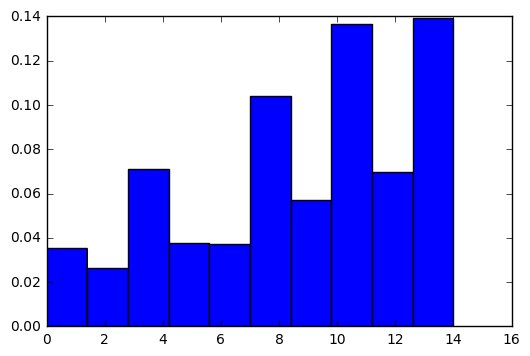

In [357]:
plt.hist(df[(df['event_created_to_end'] < 15) & (df['Fraud'] == 0)]['event_created_to_end'], normed=1)

(array([  46.,  104.,  154.,   81.,  127.,   30.,   41.,   13.,   30.,   10.]),
 array([ -1. ,   0.5,   2. ,   3.5,   5. ,   6.5,   8. ,   9.5,  11. ,
         12.5,  14. ]),
 <a list of 10 Patch objects>)

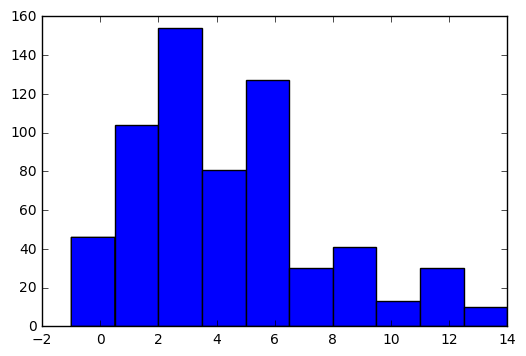

In [358]:
plt.hist(df[(df['event_created_to_end'] < 15) & (df['Fraud'] != 0)]['event_created_to_end'])

In [355]:
sorted(zip(clf.feature_importances_, [i for i in final]))[::-1]

[(0.30329319717992337, 'total_tickets_sold'),
 (0.099070030233318257, u'sale_duration2'),
 (0.086418387370996969, 'event_created_to_end'),
 (0.079499922101642806, u'sale_duration'),
 (0.071058637224877708, u'user_age'),
 (0.051278760797215536, 'median_ticket_cost'),
 (0.048262615330940041, 'MISSING'),
 (0.034215950471670517, u'user_created'),
 (0.032020911749154335, u'user_type'),
 (0.031410423311220556, u'org_facebook'),
 (0.027356127213497984, u'num_payouts'),
 (0.023082497126656339, u'num_order'),
 (0.022274135476237435, u'gts'),
 (0.015240234064270042, u'body_length'),
 (0.013365738219710344, u'name_length'),
 (0.0082950348893811188, u'channels'),
 (0.0075302943829215667, 'event_duration'),
 (0.0071304451651821293, u'delivery_method'),
 (0.0070099309498323492, u'org_twitter'),
 (0.0062519166619588633, u'has_logo'),
 (0.0046586138185397939, u'fb_published'),
 (0.004081962324984441, u'show_map'),
 (0.0034567282635654, u'GB'),
 (0.0031254883305689382, u'CHECK'),
 (0.002847486880635935

In [221]:
final.sale_duration.unique()

array([   0.,  132.,    6.,   20.,    9.,    4.,    5.,   -3.,   11.,
          1.,   40.,    8.,   18.,   13.,    2.,    3.,   16.,   14.,
         10.,   36.,   72.,  207.,   22.,    7.,   24.,   23.,  109.,
         17.,   30.,   15.,   26.,   19.,   51.,   37.,   61.,  135.,
         94.,   32.,   41.,   59.,   75.,   44.,  113.,   31.,   70.,
         56.,  195.,   21.,   25.,  131.,   91.,   43.,  111.,   27.,
         53.,   29.,   12.,  167.,   33.,  107.,   84.,   74.,   80.,
        143.,   85.,  188.,   77.,  152.,  792.,  504.,   34.,   39.,
         28.,   54.,   63.,   65.,   35.,   71.,  185.,   38.,   46.,
        100.,   60.,  120.,   68.,   97.,   66.,   49.,  219.,   47.,
         62.,   42.,  281.,   48.,  114.,  158.,   58.,   50.,   55.,
         45.,  270.,  145.,   86.,   52.,   79.,   64.,  116.,  189.,
        -37.,  178.,  186.,   78.,  153.,   67.,  128.,  106.,   87.,
         57.,  122.,  151.,  141.,   81.,  104.,  276.,  161.,  247.,
         69.,  105.,

12452